In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 불러오기

In [2]:
pd.set_option("display.max_columns", None)
df = pd.read_csv('./creditcard.csv')
print(df.head())
print(df.info())
print(df.describe())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20 

0    284315
1       492
Name: Class, dtype: int64

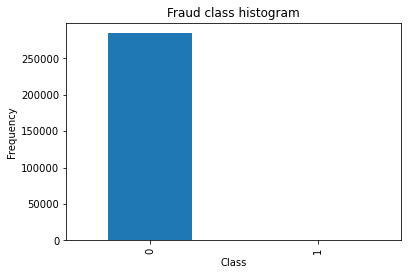

In [3]:
pd.value_counts(df['Class']).plot.bar()
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df['Class'].value_counts()

# 스케일링

In [4]:
# from sklearn.preprocessing import StandardScaler

# data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
# data = data.drop(['Time', 'Amount'], axis=1)
# data.head()

In [5]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

target = 'Time'
data = df[target].values.reshape(-1, 1)
print('\nTime_unscaled : \n' , data)
df[target] = robust_scaler.fit_transform(data)
print('\nTime_scaled : \n' , data)

target = 'Amount'
data = df[target].values.reshape(-1, 1)
print('\nAmount_unscaled : \n' ,data)
df[target] = robust_scaler.fit_transform(data)
print('\nAmount_scaled : \n' ,data)



Time_unscaled : 
 [[0.00000e+00]
 [0.00000e+00]
 [1.00000e+00]
 ...
 [1.72788e+05]
 [1.72788e+05]
 [1.72792e+05]]

Time_scaled : 
 [[-0.99498349]
 [-0.99498349]
 [-0.99497175]
 ...
 [ 1.03497457]
 [ 1.03497457]
 [ 1.03502156]]

Amount_unscaled : 
 [[149.62]
 [  2.69]
 [378.66]
 ...
 [ 67.88]
 [ 10.  ]
 [217.  ]]

Amount_scaled : 
 [[ 1.78327395]
 [-0.26982463]
 [ 4.98372109]
 ...
 [ 0.64109551]
 [-0.16767973]
 [ 2.72479564]]


# 스플릿

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('Class', axis=1)
y = df['Class']

print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print("x_train dataset: ", x_train.shape)
print("y_train dataset: ", y_train.shape)
print("x_test dataset: ", x_test.shape)
print("y_test dataset: ", y_test.shape)

Shape of X: (284807, 30)
Shape of y: (284807,)
x_train dataset:  (227845, 30)
y_train dataset:  (227845,)
x_test dataset:  (56962, 30)
y_test dataset:  (56962,)


# 샘플링 
# (+ 결과 pickle 저장_샘플링 시간 절약)

최종 적용할 샘플링 기법 : SMOTE ADASYN CNN SMOTE + ENN ADASYN + ENN

참고용으로 확인해 볼 샘플링 기법 : TomekLink SMOTE + TomekLink

=> 우리가 사용하는 데이터에서는 Tomek Link 쌍이 없기 때문에 사용할 의미가 없다.

random_state는 2로 통일

In [7]:
%%time

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.combine import SMOTEENN

X_samples = {'Raw': x_train}
y_samples = {'Raw': y_train}

#n_jobs : 시간 단축 위해
samplers = {'SMOTE' : SMOTE(random_state=2,n_jobs=-1),
            'ADASYN': ADASYN(random_state=2,n_jobs=-1),
            'CNN'   : CondensedNearestNeighbour(random_state=2,n_jobs=-1),
            'SMOTEENN': SMOTEENN(random_state=2,n_jobs=-1)}
            
for name, sampler in samplers.items():
    X_samples[name], y_samples[name] = sampler.fit_resample(x_train, y_train)

    print('\nX_samples : ',len(X_samples),'y_samples : ',len(y_samples))
    
    print('After OverSampling, the shape of train_X: {}'.format(x_train.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
    
    with open('x_samples.pickle','wb')as f:
        pickle.dump(X_samples,f,pickle.HIGHEST_PROTOCOL)
    with open('y_samples.pickle','wb')as f:
        pickle.dump(y_samples,f,pickle.HIGHEST_PROTOCOL)


X_samples :  2 y_samples :  2
After OverSampling, the shape of train_X: (227845, 30)
After OverSampling, the shape of train_y: (227845,) 

After OverSampling, counts of label '1': 408
After OverSampling, counts of label '0': 227437

X_samples :  3 y_samples :  3
After OverSampling, the shape of train_X: (227845, 30)
After OverSampling, the shape of train_y: (227845,) 

After OverSampling, counts of label '1': 408
After OverSampling, counts of label '0': 227437

X_samples :  4 y_samples :  4
After OverSampling, the shape of train_X: (227845, 30)
After OverSampling, the shape of train_y: (227845,) 

After OverSampling, counts of label '1': 408
After OverSampling, counts of label '0': 227437

X_samples :  5 y_samples :  5
After OverSampling, the shape of train_X: (227845, 30)
After OverSampling, the shape of train_y: (227845,) 

After OverSampling, counts of label '1': 408
After OverSampling, counts of label '0': 227437
Wall time: 3h 44min 58s


In [27]:
X_test = {'Raw': x_train}
y_test = {'Raw': y_train}

for name, sampler in samplers.items():
    X_test[name], y_test[name] = sampler.fit_resample(X_test, y_test)
#     X_test[f'{name}'] = x_test
#     y_test[f'{name}'] = y_test 
    print('\X_test : ',len(X_test),'y_test : ',len(y_test))
    
    print('After OverSampling, the shape of test_X: {}'.format(x_test.shape))
    print('After OverSampling, the shape of test_y: {} \n'.format(y_test.shape))

    print("After OverSampling, counts of label '1': {}".format(sum(y_test==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_test==0)))
    
    with open('x_test.pickle','wb')as f:
        pickle.dump(X_samples,f,pickle.HIGHEST_PROTOCOL)
    with open('y_test.pickle','wb')as f:
        pickle.dump(y_samples,f,pickle.HIGHEST_PROTOCOL)

RecursionError: maximum recursion depth exceeded

In [ ]:
#샘플링 시간 오래걸리니까 우선 smote만 test 

# %%time
# from imblearn.over_sampling import SMOTE

# print('After OverSampling, the shape of train_X: {}'.format(x_train.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

# print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
# print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

# X_samples = {'Raw': x_train}
# y_samples = {'Raw': y_train}

# samplers = {'SMOTE' : SMOTE(random_state=2)}
            
# for name, sampler in samplers.items():
#     X_samples[name], y_samples[name] = sampler.fit_resample(x_train, y_train)
#     with open('x_samples_{}.pickle'.format(name),'wb')as f:
#         pickle.dump(sampler,f,pickle.HIGHEST_PROTOCOL)
#     print('After OverSampling, the shape of train_X: {}'.format(x_train.shape))
#     print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

#     print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
#     print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

# pickle 불러오기

In [22]:
with open(f"./samples/X_samples.pickle", "rb") as f:
    x_train = pickle.load(f)
    
with open(f"./samples/y_samples.pickle", "rb") as f:
    y_train = pickle.load(f)
    
with open(f"./samples/X_test.pickle", "rb") as f:
    x_test = pickle.load(f)
    
with open(f"./samples/y_test.pickle", "rb") as f:
    y_test = pickle.load(f)

In [24]:
print('X_samples key : ' , X_samples.keys()) 
print('y_samples key : ' , y_samples.keys())
# print(x_test.head())
# print(y_test.head())

X_samples key :  dict_keys(['Raw', 'SMOTE', 'ADASYN', 'CNN', 'SMOTEENN'])
y_samples key :  dict_keys(['Raw', 'SMOTE', 'ADASYN', 'CNN', 'SMOTEENN'])


In [25]:
data_list = ['Raw', 'SMOTE', 'ADASYN', 'CNN', 'SMOTE + ENN', 'ADASYN + ENN']
cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC_AUC']

# 모델 적용 (KNN)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5)

data_dict = {}
for i in data_list:
    print(i)
#     clf.fit(X, y)
    clf.fit(X_samples.get(data_list[data_list.index(i)]), y_samples.get(data_list[data_list.index(i)]))
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
print("classifier created")

Raw


ValueError: Expected 2D array, got scalar array instead:
array={'Raw':             Time        V1        V2        V3        V4        V5        V6  \
136700 -0.033659 -0.626902  1.172790  1.750623  0.868050  0.015424 -0.771009   
43219  -0.508371 -0.006068 -2.885932 -0.764538  0.091419 -1.687394 -0.859819   
18819  -0.644979 -0.531514  0.611990  1.677510  1.281703  0.468128  0.025695   
174557  0.437916  1.789550 -0.556617 -1.534874  0.343963  0.202157  0.118209   
120641 -0.103244  1.254183 -0.106286 -0.882852  0.308304  1.985428  3.808663   
...          ...       ...       ...       ...       ...       ...       ...   
33867  -0.555411  1.256867  0.413152  0.322996  0.685660 -0.299566 -1.054102   
84434  -0.286528 -1.093034  1.621979  1.334661  0.818556 -0.181152 -0.660391   
95816  -0.225708 -0.799005  0.205982  1.512178  0.128515 -0.861328  0.635684   
203245  0.587895  2.012512 -0.055116 -1.245330  0.272995  0.230934 -0.609708   
100879 -0.200167  1.292856 -1.112757  1.761397 -0.087415 -2.243419 -0.096352   

              V7        V8        V9       V10       V11       V12       V13  \
136700  1.017371 -0.533478 -0.424700  0.243931  0.065733  0.343858  0.827615   
43219   0.624534 -0.416351 -0.654780  0.274192 -0.695532 -1.127895 -1.119963   
18819   0.900121 -0.306788  0.252843  0.471176 -0.622090 -0.620314 -1.319585   
174557 -0.227615 -0.003945  0.972636 -0.548941 -1.383578 -0.090648  0.517222   
120641 -0.684194  0.938692  0.416300 -0.058576 -0.641114  0.277031 -0.201467   
...          ...       ...       ...       ...       ...       ...       ...   
33867   0.141748 -0.249886 -0.090195 -0.306468  0.072227  0.665936  1.036084   
84434   0.597445  0.157340 -1.014495 -0.407656 -0.454624  0.392683  0.886625   
95816  -0.432034  0.758099  0.452072 -0.930030 -1.437812 -0.134925 -0.614330   
203245  0.207339 -0.220928  0.423374  0.013327  0.694155  1.685742  0.978553   
100879 -1.640693  0.275311  0.886617  0.300522 -1.092211 -0.681716 -1.347632   

             V14       V15       V16       V17       V18       V19       V20  \
136700 -0.187471  1.087049 -0.444573 -0.284129 -0.166159  0.343466  0.017828   
43219   0.217697 -0.001202  0.680765  0.715523 -1.358124  0.586411  1.473102   
18819  -0.215458  0.424913 -1.335135  0.475083 -0.598703  0.755992  0.170019   
174557 -1.330589  0.742572  1.140206 -0.026063  0.435850  0.127112  0.222229   
120641 -0.005331 -0.242579 -0.049570 -0.504435  0.052184  0.337316 -0.048902   
...          ...       ...       ...       ...       ...       ...       ...   
33867  -0.448733  1.005042  0.440469 -0.051501 -0.398653 -0.203949 -0.028844   
84434   0.408923  1.033171 -0.270605 -0.015873  0.026312  0.516262 -0.052241   
95816  -0.100408  0.342841 -0.571876  0.799367 -0.446101  1.420343  0.117807   
203245  0.260383 -0.852009 -0.204911 -0.667519 -0.197015  0.668118 -0.149817   
100879 -1.114945 -1.253126  0.524809  1.085152 -1.310845  0.876017 -0.070721   

             V21       V22       V23       V24       V25       V26       V27  \
136700  0.070241  0.369148 -0.063796  0.734099 -0.301282 -0.502040 -0.375145   
43219   0.584560 -0.003808 -0.801507  0.453660  0.474506 -0.140280 -0.157441   
18819  -0.145452  0.238458 -0.073162  0.066287 -0.156348 -0.283686 -0.021930   
174557 -0.307981 -1.132447  0.184282 -0.424180 -0.503949  0.134031 -0.049449   
120641 -0.137631 -0.289971 -0.132417  1.018395  0.862443 -0.282622  0.043088   
...          ...       ...       ...       ...       ...       ...       ...   
33867  -0.278275 -0.763534  0.119647  0.367553  0.243484  0.091687 -0.017777   
84434   0.168755  0.318385 -0.346367  0.427942  0.537712 -0.221692 -0.309258   
95816  -0.042553 -0.139181  0.160084 -0.409871 -0.655866  1.078683 -0.021430   
203245 -0.199295 -0.377174  0.181837 -0.402258 -0.001667 -0.539438 -0.009090   
100879  0.143809  0.718944 -0.032095  0.758703  0.393596 -0.061467  0.078662   

             V28     Amount  
136700 -0.081215  -0.028086  
43219   0.130219  10.188220  
18819  -0.245350  -0.018585  
174557  0.006778   1.893523  
120641  0.015524  -0.275274  
...          ...        ...  
33867   0.032565  -0.282401  
84434   0.001913  -0.062880  
95816   0.050234   0.747013  
203245 -0.061492  -0.131070  
100879  0.027284  -0.293440  

[227845 rows x 30 columns]}.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# knn_clf = KNeighborsClassifier(n_neighbors = 5,n_jobs=-1)
# knn_clf.fit(x_train, y_train)
# print("classifier created")

# #간단 평가
# score = knn.score(x_test,y_test)
# print("model evaluated")
# print(score)

# 평가

각 분류 모델의 성능을 평가(model selection) 방법
1. Accuracy
2. Confusion matrix
3. Precision, Recall and F-measure(f1score, f-beta-score) 
4. Receiver operating characteristic (AUC-ROC)

In [26]:
#프로모션 평가 코드
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

def evaluate(test, pred):

    confusion_mtx = confusion_matrix(test, pred)
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)
    roc_auc = roc_auc_score(y_test, y_proba[:, 1])

    
    print('오차 행렬',confusion_mtx)
    print('\n정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, fl 스코어: {:.4f}, roc_auc : {:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
pred = clf.predict(X_test)
print(evaluate(y_test,pred))

ValueError: Expected 2D array, got scalar array instead:
array={'Raw':             Time        V1        V2        V3        V4        V5        V6  \
136700 -0.033659 -0.626902  1.172790  1.750623  0.868050  0.015424 -0.771009   
43219  -0.508371 -0.006068 -2.885932 -0.764538  0.091419 -1.687394 -0.859819   
18819  -0.644979 -0.531514  0.611990  1.677510  1.281703  0.468128  0.025695   
174557  0.437916  1.789550 -0.556617 -1.534874  0.343963  0.202157  0.118209   
120641 -0.103244  1.254183 -0.106286 -0.882852  0.308304  1.985428  3.808663   
...          ...       ...       ...       ...       ...       ...       ...   
33867  -0.555411  1.256867  0.413152  0.322996  0.685660 -0.299566 -1.054102   
84434  -0.286528 -1.093034  1.621979  1.334661  0.818556 -0.181152 -0.660391   
95816  -0.225708 -0.799005  0.205982  1.512178  0.128515 -0.861328  0.635684   
203245  0.587895  2.012512 -0.055116 -1.245330  0.272995  0.230934 -0.609708   
100879 -0.200167  1.292856 -1.112757  1.761397 -0.087415 -2.243419 -0.096352   

              V7        V8        V9       V10       V11       V12       V13  \
136700  1.017371 -0.533478 -0.424700  0.243931  0.065733  0.343858  0.827615   
43219   0.624534 -0.416351 -0.654780  0.274192 -0.695532 -1.127895 -1.119963   
18819   0.900121 -0.306788  0.252843  0.471176 -0.622090 -0.620314 -1.319585   
174557 -0.227615 -0.003945  0.972636 -0.548941 -1.383578 -0.090648  0.517222   
120641 -0.684194  0.938692  0.416300 -0.058576 -0.641114  0.277031 -0.201467   
...          ...       ...       ...       ...       ...       ...       ...   
33867   0.141748 -0.249886 -0.090195 -0.306468  0.072227  0.665936  1.036084   
84434   0.597445  0.157340 -1.014495 -0.407656 -0.454624  0.392683  0.886625   
95816  -0.432034  0.758099  0.452072 -0.930030 -1.437812 -0.134925 -0.614330   
203245  0.207339 -0.220928  0.423374  0.013327  0.694155  1.685742  0.978553   
100879 -1.640693  0.275311  0.886617  0.300522 -1.092211 -0.681716 -1.347632   

             V14       V15       V16       V17       V18       V19       V20  \
136700 -0.187471  1.087049 -0.444573 -0.284129 -0.166159  0.343466  0.017828   
43219   0.217697 -0.001202  0.680765  0.715523 -1.358124  0.586411  1.473102   
18819  -0.215458  0.424913 -1.335135  0.475083 -0.598703  0.755992  0.170019   
174557 -1.330589  0.742572  1.140206 -0.026063  0.435850  0.127112  0.222229   
120641 -0.005331 -0.242579 -0.049570 -0.504435  0.052184  0.337316 -0.048902   
...          ...       ...       ...       ...       ...       ...       ...   
33867  -0.448733  1.005042  0.440469 -0.051501 -0.398653 -0.203949 -0.028844   
84434   0.408923  1.033171 -0.270605 -0.015873  0.026312  0.516262 -0.052241   
95816  -0.100408  0.342841 -0.571876  0.799367 -0.446101  1.420343  0.117807   
203245  0.260383 -0.852009 -0.204911 -0.667519 -0.197015  0.668118 -0.149817   
100879 -1.114945 -1.253126  0.524809  1.085152 -1.310845  0.876017 -0.070721   

             V21       V22       V23       V24       V25       V26       V27  \
136700  0.070241  0.369148 -0.063796  0.734099 -0.301282 -0.502040 -0.375145   
43219   0.584560 -0.003808 -0.801507  0.453660  0.474506 -0.140280 -0.157441   
18819  -0.145452  0.238458 -0.073162  0.066287 -0.156348 -0.283686 -0.021930   
174557 -0.307981 -1.132447  0.184282 -0.424180 -0.503949  0.134031 -0.049449   
120641 -0.137631 -0.289971 -0.132417  1.018395  0.862443 -0.282622  0.043088   
...          ...       ...       ...       ...       ...       ...       ...   
33867  -0.278275 -0.763534  0.119647  0.367553  0.243484  0.091687 -0.017777   
84434   0.168755  0.318385 -0.346367  0.427942  0.537712 -0.221692 -0.309258   
95816  -0.042553 -0.139181  0.160084 -0.409871 -0.655866  1.078683 -0.021430   
203245 -0.199295 -0.377174  0.181837 -0.402258 -0.001667 -0.539438 -0.009090   
100879  0.143809  0.718944 -0.032095  0.758703  0.393596 -0.061467  0.078662   

             V28     Amount  
136700 -0.081215  -0.028086  
43219   0.130219  10.188220  
18819  -0.245350  -0.018585  
174557  0.006778   1.893523  
120641  0.015524  -0.275274  
...          ...        ...  
33867   0.032565  -0.282401  
84434   0.001913  -0.062880  
95816   0.050234   0.747013  
203245 -0.061492  -0.131070  
100879  0.027284  -0.293440  

[227845 rows x 30 columns]}.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
train_acc_list=[]
test_acc_list=[]

train_pred = knn.predict(x_train)
train_acc = (train_pred == y_train).mean()
train_acc_list.append(train_acc)

test_pred = knn.predict(x_test)
test_acc = (test_pred == y_test).mean()
test_acc_list.append(test_acc)

print(train_acc)
print(test_acc)

In [ ]:
iter_range=np.linspace(1,50)
plt.plot(iter_range,train_acc_list,label='train_data')
plt.plot(iter_range,test_acc_list,label='test_data')
plt.xlabel("num of neighbors")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.show

In [ ]:
np.linspace(1,5)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate(test, pred):

    confusion_mtx = confusion_matrix(test, pred)
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)
    
    print('오차 행렬',confusion_mtx)
    print('\n정확도: {:.4f}, 정밀도: {:.4f}, 재현율: {:.4f}, fl 스코어: {:.4f}'.format(accuracy, precision, recall, f1))
    
print(evaluate(y_test,pred))

In [ ]:
#F Beta Score